# NLP - Sentiment Analysis for Amazon Product Reviews
# Pre-trained Model: Bert Neural Network (Multilingual)

In this notebook we will be doing sentiment analysis using multiple techniques:

- A) BERT Network
- B) Linear Regression (statistical method) for BERT's outputs

In [19]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Libraries for BERT & Linear Regression
import sklearn
import statsmodels.api as sm
import torch
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from statsmodels.regression.linear_model import OLS
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

# To set gray background at graphs
plt.style.use('ggplot')

In [13]:
# Read scraped results from CSV
df = pd.read_csv('Whey_Protein_Amazon_Preprocessed_Reviews.csv')

In [16]:
# Change data type for 'Review' to 'string' & fill empty cells (from CSV) with NA
df['Reviews'] = df['Reviews'].astype('string')
df = df.fillna('NA')
# Drop extra unnamed column
#col_0 = df.columns[0]
#df.drop(col_0, axis = 1, inplace = True)

## Bert Sentiment Analysis Approach

In [20]:
MODEL = f"nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [21]:
example_text = "This is the best whey protein I've ever had, although it has a weird taste if mixed with water"
print(example_text)

This is the best whey protein I've ever had, although it has a weird taste if mixed with water


In [22]:
bert_tokens = tokenizer.encode(example_text, return_tensors = 'pt')

In [24]:
bert_result = model(bert_tokens)

In [25]:
# This provides sequence classifier output - each position represents 1,2,3,4,5; the bigger and more 
# negative at 3th, 4th, 5th positions implies a 'negative sentiment'
bert_result.logits

tensor([[-2.4567, -2.2682, -0.6953,  1.8302,  3.0727]],
       grad_fn=<AddmmBackward0>)

In [26]:
# The higher the result the better although this result should be a True Positive 4 or 5
int(torch.argmax(bert_result.logits)) + 1

5

In [31]:
# Now we define a function to run for BERT Model
def bert_sentiment_scores(example):
    tokens = tokenizer.encode(example, return_tensors = 'pt')
    result = model(tokens)
    return int(torch.argmax(result.logits)) + 1    

In [32]:
# 514 is the limit of sequences per text
df['bert_sentiment'] = df['Reviews'].apply(lambda x: bert_sentiment_scores(x[:514]))

In [37]:
df = df[['ID', 'Product_Name', 'Date', 'Rating_Score', 'bert_sentiment', 'Reviews', 'Product_ID']]

In [38]:
# Now we verify that our bert sentiment was generated
df.head()

,ID,Product_Name,Date,Rating_Score,bert_sentiment,Reviews,Product_ID
0,0,NatureWorks-HydroMATE-Electrolytes-Chocolate-C...,2023-01-25,5.0,5,I love this. I make it for myself and my kids...,B0BRT77ZK8
1,1,NatureWorks-HydroMATE-Electrolytes-Chocolate-C...,2023-02-06,5.0,5,Takes away lightheadedness and makes my husba...,B0BRT77ZK8
2,2,NatureWorks-HydroMATE-Electrolytes-Chocolate-C...,2023-01-27,5.0,5,The chocolate tastes delicious! I drink it ev...,B0BRT77ZK8
3,3,NatureWorks-HydroMATE-Electrolytes-Chocolate-C...,2023-01-27,5.0,5,I absolutely love this! My buddy gave me a fe...,B0BRT77ZK8
4,4,NatureWorks-HydroMATE-Electrolytes-Chocolate-C...,2023-02-18,4.0,4,I like to work out regularly. This includes w...,B0BRT77ZK8


## Bert-Sentiment Pie Chart Results vs Actual Scores

bert_sentiment
1     192
2     361
3     529
4     849
5    1383
dtype: int64


<Axes: >

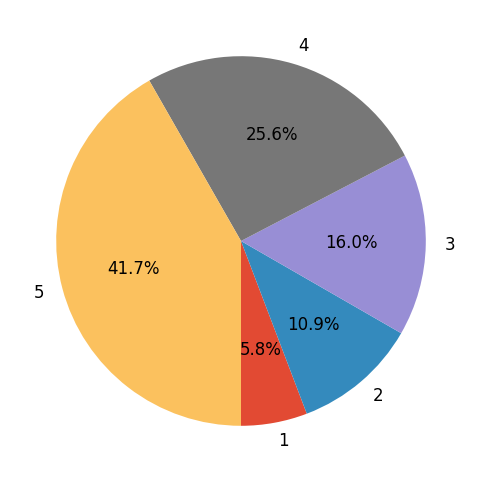

In [47]:
# Let's count the number of stars given to comments
bert_sentiment_counts = df.groupby(['bert_sentiment']).size()

# '1' stands for 1-star, '2' for 2-stars, etc.
print(bert_sentiment_counts)

# Let's visualize the sentiments
fig = plt.figure(figsize = (6,6), dpi = 100)
ax = plt.subplot(111)
bert_sentiment_counts.plot.pie(ax = ax, autopct = '%1.1f%%', startangle = 270, fontsize = 12, label = "")

Rating_Score
1.0      74
2.0     108
3.0     294
4.0     738
5.0    2100
dtype: int64


<Axes: >

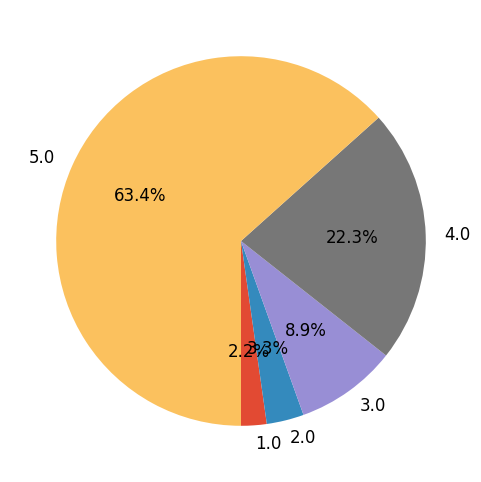

In [49]:
# Let's count the number of stars given to comments
actual_score_counts = df.groupby(['Rating_Score']).size()

# '1' stands for 1-star, '2' for 2-stars, etc.
print(actual_score_counts)

# Let's visualize the actual Score 
fig = plt.figure(figsize = (6,6), dpi = 100)
ax = plt.subplot(111)
actual_score_counts.plot.pie(ax = ax, autopct = '%1.1f%%', startangle = 270, fontsize = 12, label = "")

In [50]:
# If we compare results, noticed that bert sentiments are less biased towards a score of a'5-star' review,
# hence we can expect this model to be less precise and less efficient when it comes to prediction.

print(bert_sentiment_counts)
print(actual_score_counts)

bert_sentiment
1     192
2     361
3     529
4     849
5    1383
dtype: int64
Rating_Score
1.0      74
2.0     108
3.0     294
4.0     738
5.0    2100
dtype: int64


# Bert-Sentiment Distribution

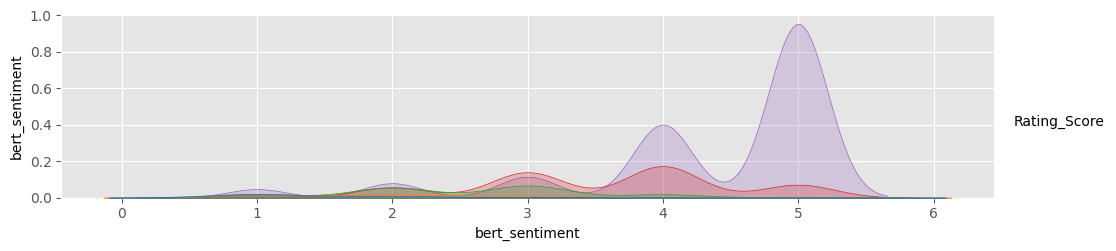

In [46]:
# Purple= 5.0-star rating
# Red= 4.0-star rating
# Green= 3.0-star rating
# Orange= 2.0-star rating
# Blue= 1.0-star rating

sns.pairplot(data = df,
             vars = ['bert_sentiment'],
            hue = 'Rating_Score',
            palette = 'tab10',
            aspect = 388.7/95.27)
plt.show()

## Bert's approach conclusion: If we compare the pie chart results, noticed that bert sentiments are less biased towards a score of a'5-star' review (unlike the actual customers' rating scores), hence we can expect this model to be less precise and less efficient when it comes to prediction. However, Bert's sentiment distribution graph appears to be perfectly separated by 5 'lumps' unlike the previously mentioned models (Vader vs Roberta - Part 4)

In [53]:
# Converting Bert results dataframe to a csv file
df.to_csv('Whey_Protein_Bert_Results.csv') 

# Bert-Sentiment Linear Regression

In [54]:
bert_lin_reg_df = pd.read_csv('Whey_Protein_Bert_Results.csv')

In [55]:
bert_lin_reg_df['Rating_Score'] = bert_lin_reg_df['Rating_Score'].astype('float')
bert_lin_reg_df['bert_sentiment'] = bert_lin_reg_df['bert_sentiment'].astype('float')

X = pd.DataFrame(bert_lin_reg_df['Rating_Score'])
y = pd.DataFrame(bert_lin_reg_df['bert_sentiment'])

# We will split our dataset into train and test sets (80% for training, and 20% for testing). 
# The regression model will learn from training data where the output is known, and later we will generalize 
# the model on the test set. We will predict the test set’s y values output and comparing these predictions 
# with the actual values.

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)

# Linear Regression Model Results
bert_model = sm.OLS(y_train, X_train)
bert_model = bert_model.fit()
print(bert_model.summary2())

# Notice on the next RESULTS we are observing 662 data points; and R-squared (goodness of model from 0 to 1) is 0.94;
# If p-value > 0.05 then do NOT we proceed (fortunately we do!) because p-values determine whether the relationships
# that we observe in this sample also exist in the larger population.

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.936    
Dependent Variable:     bert_sentiment   AIC:                         1917.5458
Date:                   2023-02-28 20:54 BIC:                         1922.0411
No. Observations:       662              Log-Likelihood:              -957.77  
Df Model:               1                F-statistic:                 9696.    
Df Residuals:           661              Prob (F-statistic):          0.00     
R-squared (uncentered): 0.936            Scale:                       1.0589   
-----------------------------------------------------------------------------------
                   Coef.      Std.Err.        t        P>|t|      [0.025     0.975]
-----------------------------------------------------------------------------------
Rating_Score       0.8705       0.0088     98.4693     0.0000     0.8532     0.8879
------------------------------------------------

In [56]:
# Need arrays to be 2-dimensional for fitting simple linear regression data model to train data set
print(X_test.shape)
print(y_test.shape)

# Need arrays to be 1-dimensional for results for RSME & R2-Score
X_test_1d = np.squeeze(X_test)
y_test_1d = np.squeeze(y_test)

print(X_test_1d.shape)
print(y_test_1d.shape)

(2652, 1)
(2652, 1)
(2652,)
(2652,)


In [57]:
bert_predictions = bert_model.predict(X_test_1d)
bert_lin_df_results = pd.DataFrame({'Actual': y_test_1d, 'Predicted': bert_predictions})

In [59]:
# RMSE is the square root of the average squared error in the predicted y values. It measures the overall accuracy 
# of model. 
# R-squared ranging from 0 to 1. R-squared=1 indicates that the regression predictions perfectly fit the data.

# As we see our model performance dropped from 0.936 (on training data - see 'Results: Ordinary least squares') to 
# 0.347 (on test data), and we are expecting to be .997 far off on our next predictions using this model.

# Evaluate
RMSE = np.sqrt(mean_squared_error(y_test_1d, bert_predictions))
r2 = r2_score(y_test, bert_predictions)
text1 = 'RMSE or Root Mean Squared Error is: ' + str(RMSE)
text2 = 'R-Squared is: ' + str(r2)
print(text1)
print(text2)

RMSE or Root Mean Squared Error is: 0.9979279108100725
R-Squared is: 0.34663970265254074


In [60]:
# Fitting Simple Linear regression data model to train data set
regressorObject = LinearRegression()
regressorObject.fit(X_train, y_train)

# Predict the test set
y_pred_test_data = regressorObject.predict(X_test)

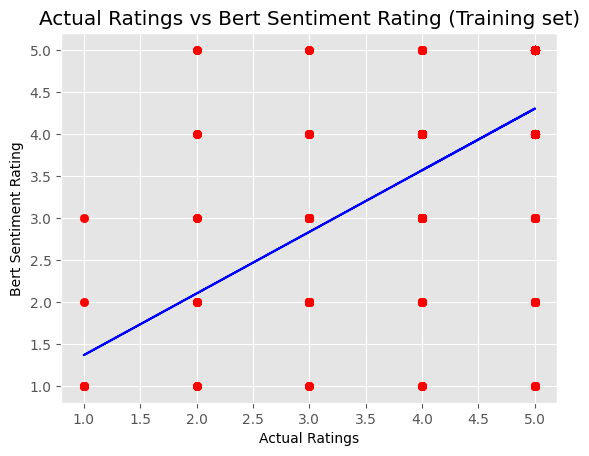

In [61]:
# Visualizing the Training set results in a scatter plot
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, regressorObject.predict(X_train), color = 'blue')
plt.title('Actual Ratings vs Bert Sentiment Rating (Training set)')
plt.xlabel('Actual Ratings')
plt.ylabel('Bert Sentiment Rating')
plt.show()

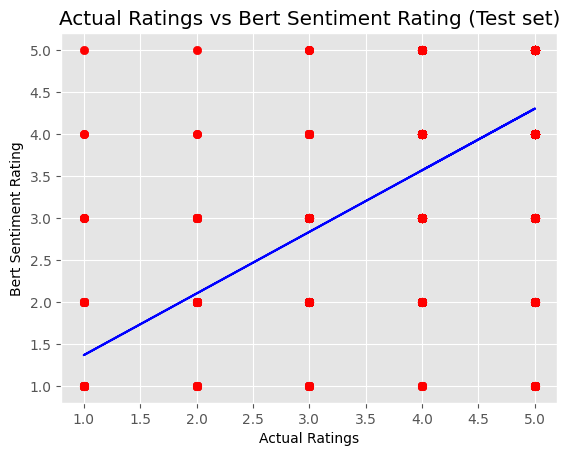

In [62]:
# Visualizing the Test set results in a scatter plot
plt.scatter(X_test, y_test, color = 'red')
plt.plot(X_train, regressorObject.predict(X_train), color = 'blue')
plt.title('Actual Ratings vs Bert Sentiment Rating (Test set)')
plt.xlabel('Actual Ratings')
plt.ylabel('Bert Sentiment Rating')
plt.show()

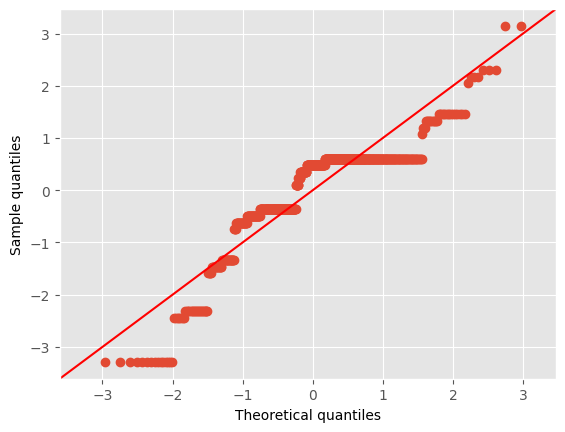

In [63]:
#We will test normality by checking with the quantile-quantile plot, Q-Q plot
fig = qqplot(bert_model.resid_pearson, line = '45' ,fit = True)
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()

## Linear regression conclusion: This supervised machine learning technique predicts that positive comments/sentiments about whey protein products will continue to be positive - although with less accuracy as bert sentiment results are not as biased towards a '5-star' sentiment compared to the real results (customer's reviews). 